<a href="https://colab.research.google.com/github/sjavierm/TP2-SOA/blob/main/HPC/Cuaderno_1_Miercoles_grupo02_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**1-Introducción**
El ejercicio 1 del trabajo practico 3 consiste en invertir los colores de una imagen.



#**2-Armado del ambiente**
##2.1 Se toma la direccion web de una imagen para tenerla disponible para la resolucion del ejercicio.  

In [ ]:

#@markdown ---
#url_imagen = "https://1.bp.blogspot.com/-W2XxUG417t4/Unkm4Ba4MPI/AAAAAAAAARw/ieGHA_ooagE/s1600/Paisajes-naturales.jpg" #@param {type:"string"}
url_imagen = "https://1.bp.blogspot.com/-W2XxUG417t4/Unkm4Ba4MPI/AAAAAAAAARw/ieGHA_ooagE/s1600/Paisajes-naturales.jpg" #@param {type:"string"}
#@markdown ---
!wget {url_imagen} -O imagen.jpg

##2.2 Se instala en el cuaderno el modulo CUDA de python.  

In [ ]:
!pip install pycuda

     |████████████████████████████████| 1.7MB 26.2MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 71kB 11.2MB/s 
     |████████████████████████████████| 81kB 13.3MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=627583 sha256=2d59d0d9185cf1c9fc4eff64f6ce0252aa108058bf8c60a4a87321addebb033b
  Stored in directory: /root/.cache/pip/wheels/d5/55/64/fd4dddcc5f1c25eebd90b5291c3769101dc978c70165685512
Successfully built pycuda
  Created wheel for pytools: filename=pytools-2021.2.7-py2.py3-none-any.whl size=60644 sha256=ae6c20a3e195b38ad1899b5fa06c578adb56494f23112a6bd7b9e17d701f6d25
  Stored in directory: /root/.cache/pip/wheels/a0/b5/e5/e65d25997fd77729b9aa214645add18688483e48bbcbab6ffc
Successfully built pytools


#**3-Desarrollo**
##3.1-CPU

In [ ]:
%matplotlib inline
from datetime import datetime

tiempo_total = datetime.now()

import  matplotlib.pyplot as plt
import numpy
from PIL import Image 

In [ ]:
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0

In [ ]:
img_nombre = 'imagen.jpg'
try:
  image = Image.open( img_nombre ) 
  if(image.format != 'JPEG'):
    raise Exception("El formato debe ser jpg")
except FileNotFoundError:
  sys.exit("No se encontró la imagen. Primero debe ejecutar el comando que descarga la imagen en la sección de armado del ambiente")
except Exception as error:
  sys.exit(error)

In [ ]:
img_ancho, img_alto = image.size 

In [ ]:
img_pic_cpu = numpy.asarray(image)
img_pic_cpu = img_pic_cpu.astype( numpy.int32() )

In [ ]:
img_picR_cpu = numpy.empty_like( img_pic_cpu)

Imagen del filtro: imagen.jpg -RGB- [1600, 1000]


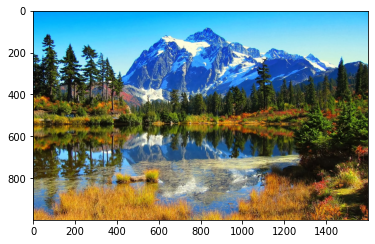

In [ ]:
print("Imagen del filtro: " + img_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )  

plt.figure()
imgplot=plt.imshow( img_pic_cpu )

In [ ]:
tiempo_img = datetime.now()

In [ ]:
for y  in range( 0, img_alto ):
  for x in range( 0, img_ancho ):
    pixel_R, pixel_G, pixel_B = img_pic_cpu[y][x]
    rojo=255-pixel_R
    verde=255-pixel_G
    azul=255-pixel_B
    
    img_picR_cpu[y][x] = [rojo,verde,azul]


In [ ]:
tiempo_img = datetime.now() - tiempo_img

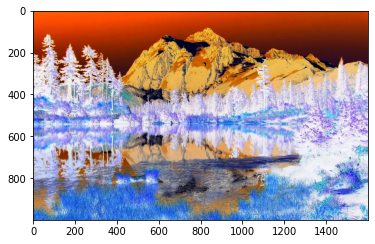

In [ ]:
plt.figure()
imgplot = plt.imshow( img_picR_cpu )


In [ ]:
tiempo_total = datetime.now() - tiempo_total


In [ ]:
print( "Tiempo de conversión de imagen:", tiempo_en_ms( tiempo_img   ), "[ms]" )
print( "Tiempo Total:",                   tiempo_en_ms( tiempo_total ), "[ms]" )

Tiempo de conversión de imagen: 21556.562 [ms]
Tiempo Total: 41507.016 [ms]


##3.2 GPU

In [ ]:
%matplotlib inline
from datetime import datetime
tiempo_total = datetime.now()
import matplotlib.pyplot as plt
import numpy
from PIL import Image 
import sys
try :
  import pycuda.driver as cuda
except ModuleNotFoundError:
  sys.exit("No se pudo importar el paquete de cuda, primero se debe ejecutar el comando que lo descarga.")
import pycuda.autoinit
from pycuda.compiler import SourceModule

In [ ]:
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0

In [ ]:
img_nombre='imagen.jpg'
try:
  imagen = Image.open( img_nombre ) 
  if(image.format != 'JPEG'):
    raise Exception("El formato debe ser jpg")
except FileNotFoundError:
  sys.exit("No se encontró la imagen, primero se debe ejecutar el comando que lo descarga.")
except Exception as error:
  sys.exit(error)


In [ ]:
img_ancho, img_alto  = imagen.size 


In [ ]:
img_O_cpu = numpy.asarray(imagen)
img_O_cpu = img_O_cpu.astype( numpy.int32() )
img_R_cpu = numpy.empty_like( img_O_cpu)

In [ ]:
img_O_gpu= cuda.mem_alloc(img_O_cpu.nbytes)
img_R_gpu = cuda.mem_alloc( img_R_cpu.nbytes )

In [ ]:
cuda.memcpy_htod( img_O_gpu, img_O_cpu )
cuda.memcpy_htod( img_R_gpu, img_R_cpu )

In [ ]:
module = SourceModule("""
__global__ void kernel_img( int ancho, int alto, int *img_O, int *img_R )
{
  // Calculo las coordenadas del Thread en dos dimensiones.
  int idx = threadIdx.x + blockIdx.x*blockDim.x;
  int idy = threadIdx.y + blockIdx.y*blockDim.y;
  float rojo = 0.0;
  float verde= 0.0;
  float azul= 0.0;

  // Verifico que los Thread, esten dentro de las dimensiones de la imagen.
  if( idx < ancho && idy < alto )
  {
    // Calculo el color gris para el pixel a partir de los componentes.
    rojo = 255-(float)img_O[(idx+(idy*ancho))*3    ];  // Componente Rojo del pixel.
    verde =255-(float)img_O[((idx+(idy*ancho))*3)+1];  // Componente Verde del pixel.
    azul = 255-(float)img_O[((idx+(idy*ancho))*3)+2];   // Componente Azul del pixel.
    // Escribo el color del pixel.
    img_R[(idx+(idy*ancho))*3  ] = (int) rojo;
    img_R[(idx+(idy*ancho))*3+1] = (int) verde;
    img_R[(idx+(idy*ancho))*3+2] = (int) azul;
  }
}
""") 

In [ ]:
kernel = module.get_function("kernel_img")


In [ ]:
tiempo_img=datetime.now()

In [ ]:
dim_hilo_x = 16
dim_bloque_x = numpy.int( (img_ancho+dim_hilo_x-1) / dim_hilo_x )

In [ ]:
dim_hilo_y = 19
dim_bloque_y = numpy.int( (img_alto+dim_hilo_y-1) / dim_hilo_y )

In [ ]:
tiempo_img=datetime.now()

In [ ]:
kernel( numpy.int32(img_ancho), numpy.int32(img_alto), img_O_gpu, img_R_gpu, block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1) )

In [ ]:
tiempo_img=datetime.now()-tiempo_img

In [ ]:
cuda.memcpy_dtoh( img_R_cpu, img_R_gpu )

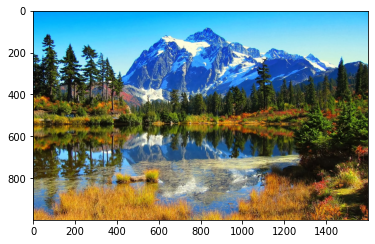

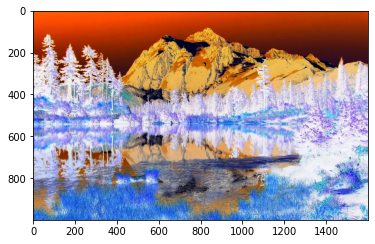

In [ ]:
plt.figure()
imgplot=plt.imshow( img_O_cpu )

plt.figure()
imgplot=plt.imshow( img_R_cpu )


In [ ]:
tiempo_total = datetime.now() - tiempo_total

print("Tiempo TOTAL: ", tiempo_en_ms( tiempo_total ), "[ms]" )
print("Tiempo GPU  : ", tiempo_en_ms( tiempo_img ), "[ms]" )

Tiempo TOTAL:  33579.147 [ms]
Tiempo GPU  :  2626.582 [ms]


#**4-Metricas**
TIEMPOS | CPU  | GPU
--------|------|-------
Tiempo de conversion de imagen|21556.562 [ms]|2626.582 [ms]
Tiempo total|41507.016 [ms]| 33579.147 [ms]

#**5-Conclusion**
* Se utilizo un software que toma como parametro principal una imagen y que, a partir de esta, se genera otra imagen pero con los colores invertidos. 
* Para esto, se comparo la ejecucion de manera secuencial(CPU) contra la ejecucion paralela desarrollada en CUDA(GPU).
* Una de las conclusiones que obtuvimos es que con la ejecucion paralela podemos obtener una mayor velocidad de ejecucion con respecto a la ejecucion secuencial.


#**6-Bibliografia**

* [CUDA](https://docs.nvidia.com/cuda/)
* [Pyonpel](https://documen.tician.de/pyopencl/)
* [Opencl](https://www.khronos.org/opencl/)
* [Matpolib](https://https://matplotlib.org/)


